In [5]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
# import regression package


# Strategy Implementation 

This chapter was not touched

So we have taken prices as given and discussed quantitative allocation rules that overperform relative to a standard CAPM benchmark.

An important question is whether we would be able to trade at those prices if we tried to implement the strategy.

Here start briefly by dsicussing how cleaning the data is really the most important step to make sure what you are finding is real and can be a profitable trading strategy.

We will then discuss at length liquidity issues.

## Data Cleaning: The devil is in the details

Eugene Fama always would tell his students: Garbage in, Garbage out

He was also able to look at a Table of a regression, or summary statistics and immediately tell that the person had 
done something different with the data when cleaning it.
When working with raw data, it is really important to undergo careful work to check if the underlying data is indeed real

CRSP dataset is very clean already, but if you are not careful your analysis will pick up features of the data are not real

- Load on microstructure effects- bid-ask bounces

- Load on tiny/peny stocks

- Load on stocks that are outside of your investment mandate (for example stocks that do not trade in the US)

- Load on other financial instruments (closed-end funds, convertible, prefered shares..)


For example, Daniel and Moskowitz in the "Momentum Crashes" paper impose the following data requriements


(a). CRSP Sharecode 10 or 11. (i.e, common stocks; no ADRs)

(b). CRSP exchange code of 1, 2 or 3 (NYSE, AMEX or NASDAQ)

(c). Must have price at date t-13

(d). Must have return at date t-2

(e). Must have market cap at date t-1





## Liquidity

Liquidity is the ease of trading a security.

This can be quite complex and encompass many things, all of which impose a cost on those wishing to trade.

Sources of illiquidity:

1. Exogenous transactions costs = brokerage fees, order-processing costs, transaction taxes.

2. Demand pressure = when need to sell quickly, sometimes a buyer is not immediately available (search costs).

3. Inventory risk = if can’t find a buyer will sell to a market maker who will later sell position.  But, since market maker faces future price changes, you must compensate him for this risk.

4. Private information = concern over trading against an informed party (e.g., insider).  Need to be compensated for this. Private information can be about fundamentals or order flow

Obviuosly a perfect answer to this question requires costly experimentation. It would require trading and measuring how prices change in reponse to your trading behavior.

**Absorption capacity**

A much simpler approach is to measure the absorption capacity of the strategy.

The idea is to measure how much of the trading volume of each stock you would "use" to implement the strategy for a given position size

Specifically:

$$UsedVolume_{i,t}=\frac{Trading_{i,t}}{Volume_{i,t}}$$

The idea is that if you trade a small share of the volume, you are likely to be able to trade at the posted prices.


To compute how much you need to trade you need to compare the desired weights in date $t$ with the weights you have in the end of date $t+1$.

* Before trading, your weight in date $t+1$ is


$$w_{i,t+1}(\text{before trading})= \frac{w_{i,t}^*(1+r_{i,t+1})}{(1+r_{t+1}^{strategy})}$$


* If the desired position in the stock is $w_{i,t+1}^*$, then

\begin{align}
UsedVolume_{i,t}&=\frac{position \times \bigg(w_{i,t+1}^*-w_{i,t+1}(\text{before trading})\bigg)}{Volume_{i,t}} \\
&=\frac{position}{Volume_{i,t}}\left(w_{i,t+1}^*-\frac{w_{i,t}^*(1+r_{i,t+1})}{1+r_{t+1}^{strategy}}\right)
\end{align}

* $UsedVolume_{i,t}$ is a stock-time specific statistic. Implementability will depend on how high this quantity is across time and across stocks-- the lower the better. 

* If it is very high (i.e., close to  1), it means that your position would require almost all volume in a particular stock. It doesn't mean that you wouldn't be able to trade, but likely prices would move against you (i.e., go up as you buy, do down as you sell)

* One very conservative way of looking at it is to look at the **maximum** of this statistic across stocks. This tells you the "weakest" link in your portfolio formation. 

* The max statistic is the right one to look at if you are unwilling to deviate from your "wish portfolio".

* But the "wish portfolio" does not take into account transaction costs

> How can portfolios take into account trading costs to reduce total costs substantially?

> Can we change the portfolios to reduce trading costs without altering them significantly?

One simple way of looking at this is to look at the  95/75/50 percentiles of the used volume distribution.

* If it declines steeply it might make sense to avoid the 5% to 25% of the stocks that are least liquid in you portfolio

* But as you deviate from the original portfolio you will have tracking error relative to the original strategy.


In [ ]:
temp=data[['permco','date','ret', 'me_comp','vol','prc']].sort_values(['permco','date']).set_index('date').drop_duplicates()

In [ ]:
temp=temp.reset_index()
temp[temp.duplicated(subset=['date','permco'],keep=False)]

,index,date,permco,ret,me_comp,vol,prc
1300,1300,1990-01-31,32,-0.143836,582.468750,2162.0,31.250000
1301,1301,1990-01-31,32,-0.131944,582.468750,3614.0,31.250000
1302,1302,1990-02-28,32,-0.080000,538.256000,1320.0,28.750000
1303,1303,1990-02-28,32,-0.072000,538.256000,1471.0,29.000000
1304,1304,1990-03-30,32,0.034783,554.867250,1829.0,29.750000
...,...,...,...,...,...,...,...
1754105,1754105,2017-10-31,55773,NaN,2508.854117,2.0,NaN
1754106,1754106,2017-11-30,55773,-0.022126,2583.637062,95594.0,45.080002
1754107,1754107,2017-11-30,55773,-0.145826,2583.637062,5.0,-46.040001
1754108,1754108,2017-12-29,55773,-0.016637,2541.522427,47669.0,44.330002


In [ ]:
# data=crsp_m.copy()
# ngroups=10

def momreturns_w(data, ngroups):
    
    # step1. create a temporary crsp dataset
    _tmp_crsp = data[['permco','date','ret', 'me_comp','vol','prc']].sort_values(['permco','date']).set_index('date').drop_duplicates()
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me

    # step 2: construct the signal
    _tmp_crsp['grossret']=_tmp_crsp['ret']+1
    _tmp_cumret=_tmp_crsp.groupby('permco')['grossret'].rolling(window=12).apply(np.prod, raw=True)-1
    _tmp_cumret=_tmp_cumret.reset_index().rename(columns={'grossret':'cumret'})

    _tmp = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permco','date','cumret']], how='left', on=['permco','date'])
    # merge the 12 month return signal back to the original database
    _tmp['mom']=_tmp.groupby('permco')['cumret'].shift(2)

    # step 3: rank assets by signal
    mom=_tmp.sort_values(['date','permco']) # sort by date and firm identifier 
    mom=mom.dropna(subset=['mom'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    # create `ngroups` groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    # in a given month 
    # transform in string the group names
    mom=mom.dropna(subset=['mom_group'], how='any')# drop the row if any of 'mom_group' is missing
    mom['mom_group']=mom['mom_group'].astype(int).astype(str).apply(lambda x: 'm{}'.format(x))

    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permco','date']) # resort 

    # step 4: form portfolio weights
    def wavg_wght(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            group['Wght']=(w) / w.sum()
            return group[['date','permco','Wght']]
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date

    weights = mom.groupby(['date','mom_group']).apply(wavg_wght, 'ret','me_comp') 

    # merge back
    weights=mom.merge(weights,on=['date','permco'])
    weights=weights.sort_values(['date','permco'])

    weights['mom_group_lead']=weights.groupby('permco').mom_group.shift(-1)
    weights['Wght_lead']=weights.groupby('permco').Wght.shift(-1)
    weights=weights.sort_values(['permco','date'])

    def wavg_ret(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan

    port_vwret = weights.groupby(['date','mom_group']).apply(wavg_ret, 'ret','Wght')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires


    weights=weights.merge(port_vwret,how='left',on=['date','mom_group'])

    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret

    return port_vwret, weights

In [ ]:
port_ret, wght=momreturns_w(crsp_m, 10)

In [ ]:
wght.head()

,date,permco,ret,me_comp,vol,prc,volume,grossret,cumret,mom,mom_group,Wght,mom_group_lead,Wght_lead,port_vwret
0,1991-02-28,4,0.129534,1096.632,12962.0,27.000,34.997400,1.129534,0.062541,-0.212395,m5,0.004269,m6,0.001975,0.077604
1,1991-03-31,4,-0.027778,1066.170,15970.0,26.250,41.921250,0.972222,0.023372,-0.008337,m6,0.001975,m6,0.002136,0.024414
2,1991-04-30,4,-0.109524,949.399,28938.0,23.375,67.642575,0.890476,-0.044041,0.062541,m6,0.002136,m5,0.002240,0.010956
3,1991-05-31,4,-0.005348,934.168,20847.0,23.000,47.948100,0.994652,-0.085034,0.023372,m5,0.002240,m4,0.002891,0.037118
4,1991-06-30,4,-0.021739,917.100,10960.0,22.500,24.660000,0.978261,-0.036073,-0.044041,m4,0.002891,m4,0.002311,-0.058240


In [ ]:
# construct dollars of each stock that need to be bought (sold) at date t+1
mom=wght.copy()
mom['trade']=mom.Wght_lead*(mom.mom_group==mom.mom_group_lead)-mom.Wght*(1+mom.ret)/(1+mom.port_vwret)


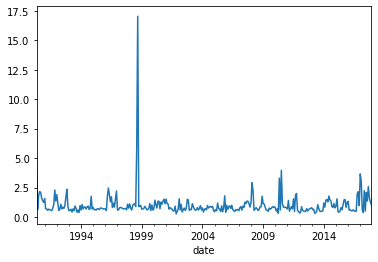

In [ ]:
# per dollar of position how much do you have to trade every month?
mom.groupby(['date','mom_group']).trade.apply(lambda x:x.abs().sum()).loc[:,'m1'].plot()

In [ ]:
# lets look at the most illiquid stocks, the stocks that I will likely have most trouble trading
# lets start by normalizing the amount of trade per stock volume

mom['tradepervol']=mom.trade/mom.volume




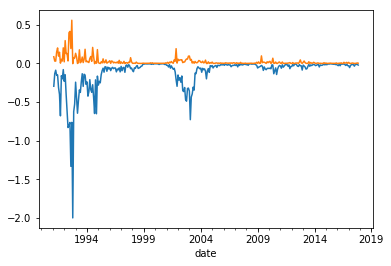

In [ ]:
# this allow us to study how much of the volume of each stock I will be "using"
# lets choose a position size, here in millions of dollars , because that is the normalization we used for the volume data
Position=1e3 #(1e3 means one billion dollars)
threshold=0.05
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(threshold).loc[:,'m9'])).plot()
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(1-threshold).loc[:,'m9'])).plot()

**Tracking error**

Let $$W^{wishportfolio}_t$$ and $$W^{Implementationportfolio}_t$$ weights , then consider the following regression

$$W^{Implementationportfolio}_tR_{t+1}=\alpha+\beta W^{wishportfolio}_tR_{t+1}+\epsilon_{t+1}$$

a good implementation portfolio has $\beta=1$ and $\sigma(\epsilon)$ and $\alpha\approx 0$.

So one can think of $|\beta-1|$, $\sigma(\epsilon)$ , and $\alpha$ as three dimensions of tracking error.

The $\beta$ dimension can be more easily correted by levering up and down the tracking portoflio (of possible)

The $\sigma(\epsilon)$ can only be corrected by simply making the implemenetation portoflio more similar to the wish portfolio. The cost of this is not obvious. Really depends how this tracking error relates to other stuff in your portfolio.

$\alpha$ is the important part. The actual cost that you expect to pay to deviate from the wish portfolio

------------------------------

In the industry people typicall refer to tracking error as simply

$$\sigma(W^{Implementationportfolio}_tR_{t+1}- W^{wishportfolio}_tR_{t+1})$$

The volatility of a portfolio that goes long the implementation portfolio and shorts the wish portfolio.

This mixes together $|\beta-1|$, $\sigma(\epsilon)$ and completely ignores $\alpha$


In the end the Implementation portfolio is chosen by trading off  trading costs (market impact) and opportunity cost (tracking error).

So you can simply construct strategies that avoid these 5% less liquid stocks, and see how much your tracking error increases and whether these tracking errors are worth the reduction in trading costs

**How to construct an Implementation portfolio?**

- A simple strategy: weight by trading volume -> this make sure that you use the same amount of trading volume across all your positions


- Harder to implement: do not buy stocks that are illiquid now or likely to be illiquid next period. Amounts to add another signal interected to the momentum signal. Only buy if illiquid signal not too strong.

How to change our code to implement the volume-weighted approach?


In [ ]:
def momreturns(data,lookback=12,nmonthsskip=1,wghtvar='me',returntransf='sum',nportfolios=10):
    

    _tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date')
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me
    ## Trading siginal construction
    _tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)#replace missing return with 0
    _tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])#transform in log returns
    if returntransf=='sum':
        _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(lookback, min_periods=np.min([7,lookback])).sum()# sum last 12 month returns for each 
    elif returntransf=='std':
        _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(lookback, min_periods=np.min([7,lookback])).std()# sum last 12 month returns for each 
    elif returntransf=='min':
        _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(lookback, min_periods=np.min([7,lookback])).min()# sum last 12 month returns for each 
    elif returntransf=='max':
        _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(lookback, min_periods=np.min([7,lookback])).max()# sum last 12 month returns for each 
 
    
    
    #stock,require there is a minium of 7 months
    
    _tmp_cumret = _tmp_cumret.reset_index()# reset index, needed to merged back below

    _tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1# transform back in geometric  returns
    _tmp_cumret = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
    # merge the 12 month return signal back to the original database

    _tmp_cumret['mom']=_tmp_cumret.groupby('permno')['cumret'].shift(1+nmonthsskip) # lag the 12 month signal by two months
 
    # You always have to lag by 1 month to make the signal tradable, that is if you are going to use the signal
    #to construct a portfolio in the beggining of january/2018, you can only have returns in the signal up to Dec/2017
    # we are lagging one more time, because the famous momentum strategy skips a month as well 

    # we also labeling mom the trading signal
    mom=_tmp_cumret.sort_values(['date','permno']).drop_duplicates() # sort by date and firm identifier and drop in case there 
    #any duplicates (IT shouldn't be, in a given date for a given firm we can only have one row)
    if wghtvar=='ew':
        mom['w']=1
    else:
        mom['w']=mom.groupby('permno')[wghtvar].shift(1) # lag the market equity that we will use in our trading strategy to construct
   
    # value-weighted returns
    mom=mom.dropna(subset=['mom','ret','me'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, nportfolios, labels=False,duplicates='drop'))

    # create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    #in a given month 



    # transform in string the group names
    mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)
    
    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permno','date']) # resort 

    # we now have the membership that will go in each portfolio
    # withing a given portfolio we will simply use the firms market cap to value-weight the portfolio

    # this function takes given date/set of firms given in group, and uses ret_name as the return series and
    # weight_name as the variable to be used for weighting

    # it returns, on number, the value weighted returns

    def wavg(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date
    port_vwret = mom.groupby(['date','mom_group']).apply(wavg, 'ret','w')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret
    
    return port_vwret

In [ ]:
momportfolios=momreturns(crsp_m,lookback=12,nmonthsskip=1,wghtvar='me',returntransf='sum',nportfolios=10)
momportfoliosvol=momreturns(crsp_m,lookback=12,nmonthsskip=1,wghtvar='vol',returntransf='sum',nportfolios=10)
momportfolios=momportfolios.merge(momportfoliosvol,left_index=True,right_index=True,suffixes=['_me','_vol'])

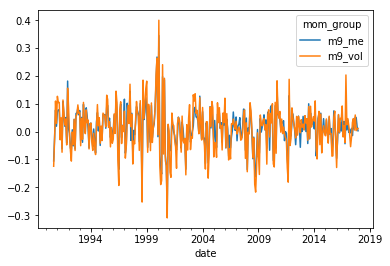

In [ ]:
momportfolios[['m9_me','m9_vol']].plot()

In [ ]:
# lets look at it's tracking error
y=momportfolios['m9_vol']
x=momportfolios['m9_me']
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 m9_vol   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     2585.
Date:                Tue, 01 Oct 2019   Prob (F-statistic):          4.82e-157
Time:                        22:13:26   Log-Likelihood:                 706.11
No. Observations:                 328   AIC:                            -1408.
Df Residuals:                     326   BIC:                            -1401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.002     -2.282      0.023      -0.007      -0.000
m9_me          1.1727      0.023     50.844      0.000       1.127       1.218
==============================================================================
Omnibus:                       59.076   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.760
Skew:                           0.743   Prob(JB):                     7.68e-46
Kurtosis:                       6.605   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations:

- The beta difference 1.17 vs 1 can be adjusted by taking a smaller position on the implementation portfolio

- The alpha is the actual tracking error loss. How much you expect to loose.

- In this case it is economically quite large -0.0036 vs $\beta E[R]$ of 0.0045

- One calculation that people do is to see how much you are getting for your momentum exposure


In [ ]:
[momportfolios['m9_vol'].mean()/results.params[1]*12,momportfolios['m9_me'].mean()*12]

[0.02273481060808451, 0.045973481561390854]

This is very large. A decay of about 50% in the premium that you earn for trading momentum

But be careful to not over interpret this. We are working today with a very short sample, less than 20 years, for average returns tests that is not much at all.

But beta/residulas are well measured even in fairly short samples.


In addition to that you also have to eat the strategy residual risk

In [ ]:
[results.resid.std(),momportfolios['m9_me'].std()]

[0.030886022623588822, 0.05839011395858583]

It is sizable, about 50% of the original strategy volatility

**How our implemented strategy compare with the desired strategy?**



In [ ]:
url = "https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1"
Factors = pd.read_csv(url,index_col=0, 
                         parse_dates=True,na_values=-99)
Factors=Factors/100

Factors=Factors.iloc[:,0:5]
Factors['MKT']=Factors['MKT']-Factors['RF']
Factors=Factors.drop('RF',axis=1)
Factors.mean()

MKT    0.006567
SMB    0.002101
HML    0.003881
Mom    0.006557
dtype: float64

In [ ]:
momportfolios=momportfolios.merge(Factors,left_index=True,right_index=True)
momportfolios.head()

,m0_me,m1_me,m2_me,m3_me,m4_me,m5_me,m6_me,m7_me,m8_me,m9_me,...,m4_vol,m5_vol,m6_vol,m7_vol,m8_vol,m9_vol,MKT,SMB,HML,Mom
2000-09-30,-0.129798,-0.127564,-0.059888,0.010082,-0.000143,-0.010516,-0.020118,-0.062108,-0.015532,-0.148530,...,-0.078569,-0.102002,-0.041797,-0.071430,-0.042302,-0.103630,-0.0545,-0.0140,0.0623,0.0215
2000-10-31,-0.193803,0.015573,-0.002240,0.051042,0.056879,0.002350,-0.013423,-0.024685,-0.052272,-0.083327,...,0.016559,-0.041332,-0.034236,-0.040717,-0.066250,-0.085599,-0.0276,-0.0377,0.0555,-0.0463
2000-11-30,-0.331351,-0.173224,-0.081811,-0.055005,-0.079905,-0.080539,-0.063107,-0.054668,-0.094147,-0.228494,...,-0.164590,-0.146529,-0.169296,-0.106301,-0.155380,-0.284814,-0.1072,-0.0277,0.1129,-0.0244
2000-12-31,-0.172035,-0.064091,-0.038472,0.062127,0.083423,-0.009017,-0.002741,0.043720,0.020615,0.085389,...,0.054782,-0.017112,-0.028978,0.044208,0.016709,0.085327,0.0119,0.0096,0.0730,0.0673
2001-01-31,0.418582,0.397816,0.299617,0.095205,0.093103,0.083798,-0.014023,-0.010242,-0.046882,-0.069165,...,0.165616,0.093876,0.078421,0.021932,0.019839,0.000049,0.0313,0.0656,-0.0488,-0.2501


In [ ]:
# things to look at:

#y=momportfolios['m9_me']
#y=momportfolios['m9_vol']
#y=momportfolios['m9_me']-momportfolios['m0_me']


y=momportfolios['m9_me']-momportfolios['m0_me']
x=momportfolios[['MKT','Mom']]
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     387.0
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           2.61e-69
Time:                        11:48:12   Log-Likelihood:                 322.62
No. Observations:                 202   AIC:                            -639.2
Df Residuals:                     199   BIC:                            -629.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      0.767      0.444      -0.004       0.010
MKT           -0.2234      0.089     -2.505      0.013      -0.399      -0.048
Mom            1.7587      0.075     23.590      0.000       1.612       1.906
==============================================================================
Omnibus:                       26.262   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.262
Skew:                          -0.182   Prob(JB):                     2.58e-30
Kurtosis:                       7.007   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

why such a large differcenc even for the strategy that follows the Momentum strategy?